Import the libraries

In [1]:
import os

import tensorflow as tf

import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# set the random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Load and inspect the dataset

In [3]:
#read the dataset from csv file using pandas dataframe
#dataset = pd.read_csv("Training.csv")
dataset = pd.read_csv("/kaggle/input/training/Training.csv")
print(dataset.shape)
dataset.head()  #show first rows of the dataframe

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
#print some information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


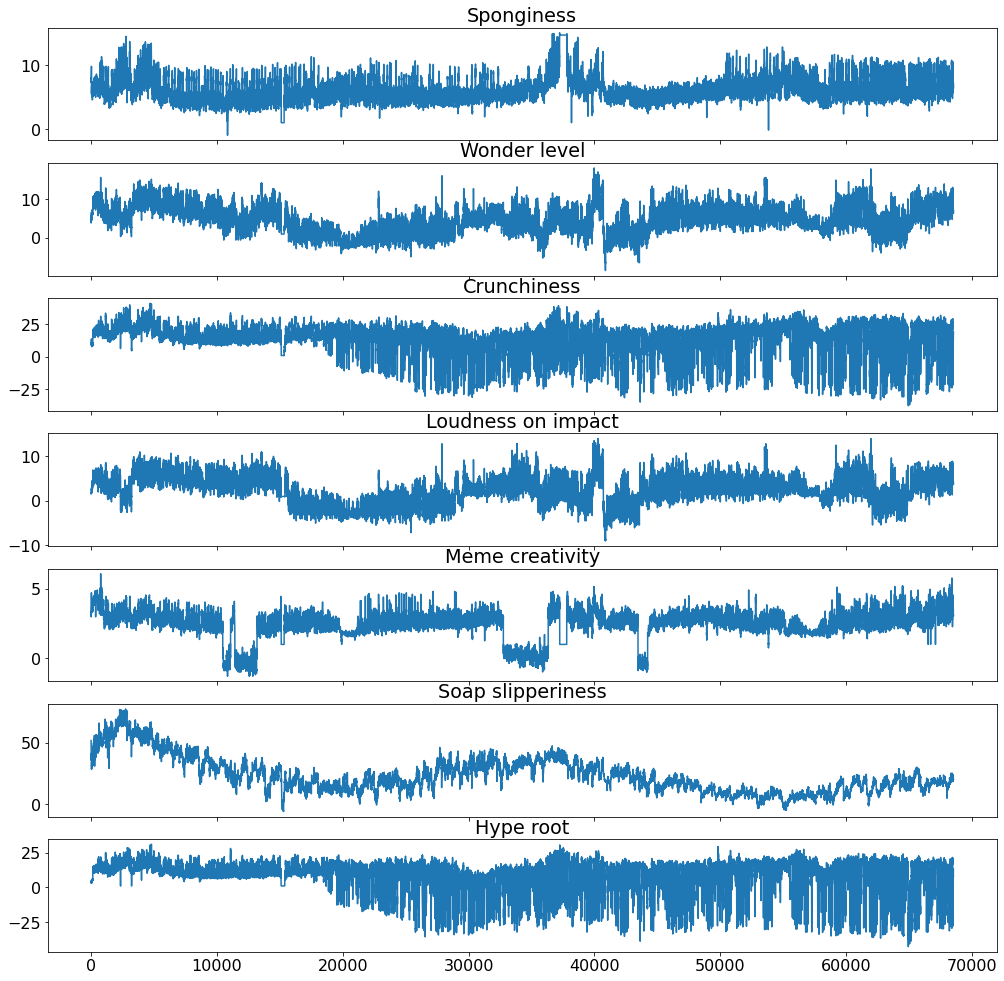

In [5]:
#function to plot the dataset, dividing it in subplots, one for each feature
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe(dataset, dataset.columns)

Train/test split and normalization of the features

In [6]:
split_percentage=0.15
#define how many test samples to use
test_size = int(dataset.shape[0]*split_percentage)

#for training take the first rows of the dataset except the last "test_size" which are reserved for testing. 
# pandas .iloc() is Purely integer-location based indexing for selection by position
X_train_raw = dataset.iloc[:-test_size]

#for testing take the last "test_size" samples from the dataset
X_test_raw = dataset.iloc[-test_size:]

#show shape of X_train_row and X_test_raw --> ("dataset_size"-"test_size", 7) & ("test_size", 7)
print(X_train_raw.shape, X_test_raw.shape)

# Normalize features, on normalization use always just the training set, never testing set, normalize using training set
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min) #minMax scaler normalization of training samples
X_test_raw = (X_test_raw-X_min)/(X_max-X_min) #minMax scaler normalization of testing samples

(58249, 7) (10279, 7)


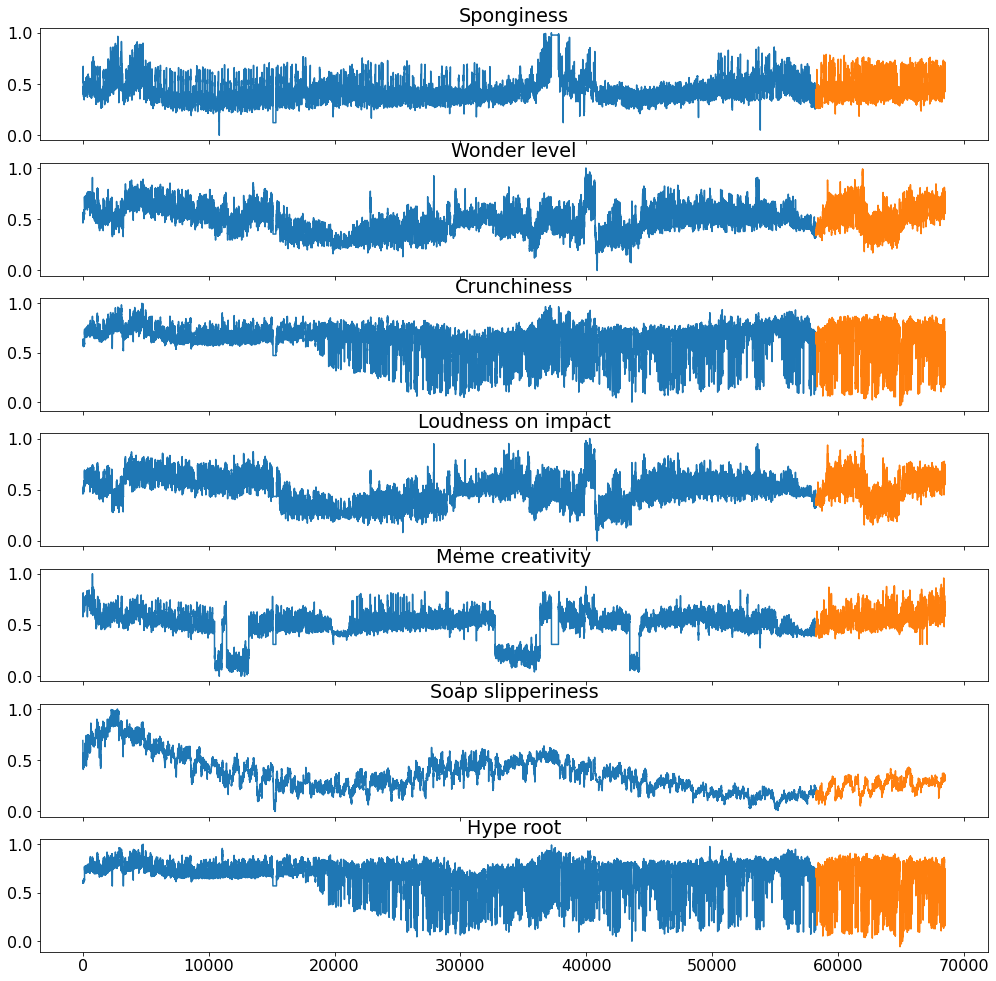

In [7]:
#function to plot the normalized dataset together with the split in training and testing
def inspect_normalized_dataframe(train,test,columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(train[col],label='Train')
        axs[i].plot(test[col], label='Test')
        axs[i].set_title(col)
    plt.show()

inspect_normalized_dataframe(X_train_raw, X_test_raw, dataset.columns)


Define parameters for the sequences

In [8]:
window = 100 #how many samples are considered each time
stride = 100 #how much to shift window at each iteration
telescope = 864 #how many samples to predict in the future
target_labels = dataset.columns #save the names of the columns

Function that creates the sequences to train the model

In [9]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0 #check that stride is sub-multiple of window size
    dataset = []
    labels = []
    
    temp_df = df.copy().values #create a dataframe containing the values extracted from variable passed df
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window  #check if padding is necessary wrt window size

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
#create traing and test sets, we want to predict all 7 features
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope) #pass training dataframe
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope) #pass testing dataframe
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((574, 100, 7), (574, 864, 7), (94, 100, 7), (94, 864, 7))

function to show example of the dataset

In [11]:
#function to plot examples from the training set, one sample, that is 7 time series
#blue part is the values that we give as input to network, orange part is the target to predict

def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

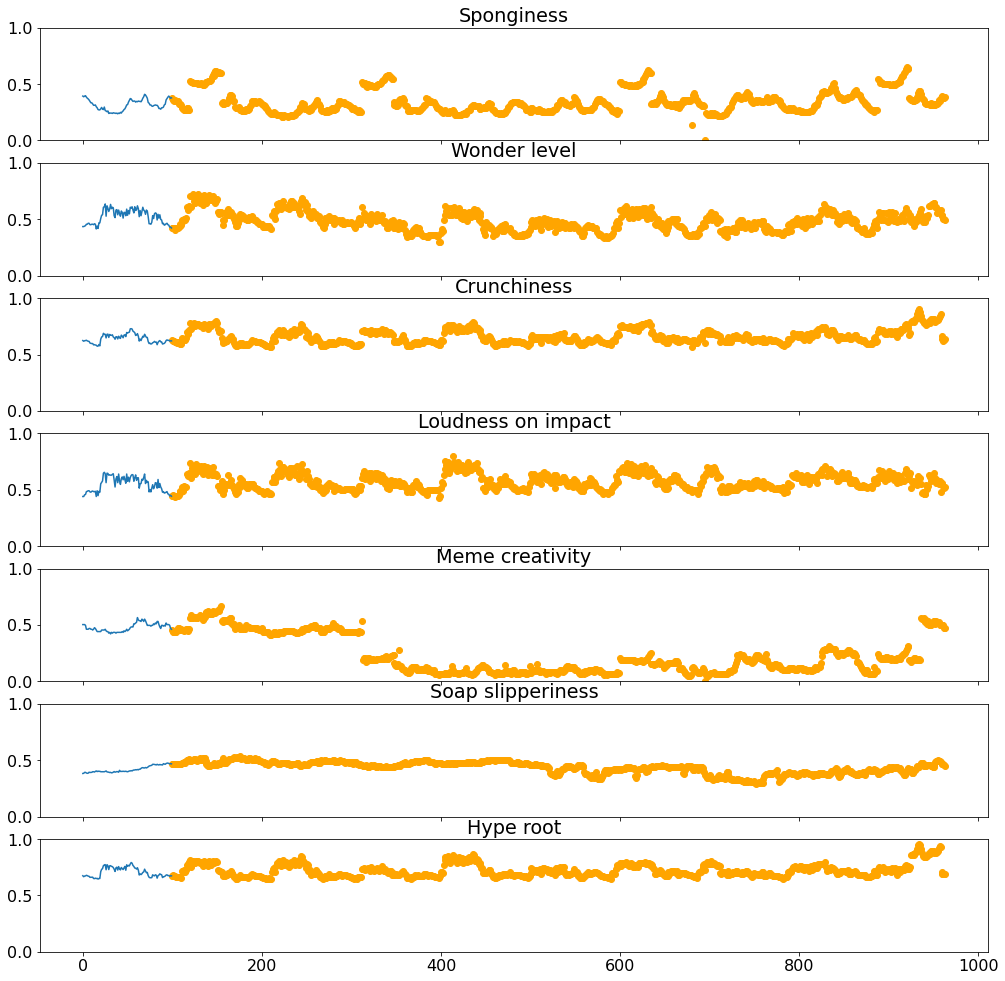

In [12]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

Define training parameters

In [13]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print(input_shape)
print(output_shape)
batch_size = 128
epochs = 5000


(100, 7)
(864, 7)


Model building

In [14]:
#build the parallel branches
def build_branch(i):
    conv=tfk.Sequential([

        tfkl.LSTM(100,return_sequences = True,kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(0.1),
        tfkl.LSTM(100,return_sequences = True,kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(0.1),
        tfkl.LSTM(100,kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(0.1),
        tfkl.Dense(512,activation='relu',kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(0.2),
        tfkl.Dense(output_shape[0], activation='relu',kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Reshape((output_shape[0],1))
        
        
    ],name="branch_"+str(i))
    return conv

def build_model(input_shape,output_shape):
    
    inputs=[]
    branches=[]

    for i in range(input_shape[-1]):
        inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(i)))
        branches.append(build_branch(i)(inputs[i])) 

    #define losses for every output branch
    losses = {
            "branch_0": tfk.losses.MeanSquaredError(),
            "branch_1": tfk.losses.MeanSquaredError(),
            "branch_2": tfk.losses.MeanSquaredError(),
            "branch_3": tfk.losses.MeanSquaredError(),
            "branch_4": tfk.losses.MeanSquaredError(),
            "branch_5": tfk.losses.MeanSquaredError(),
            "branch_6": tfk.losses.MeanSquaredError()   

        }
    #define losses weights for every output branch
    losses_weights = {
            "branch_0": 1.0,
            "branch_1": 1.0,
            "branch_2": 1.0,
            "branch_3": 1.0,
            "branch_4": 1.0,
            "branch_5": 1.0,
            "branch_6": 1.0
    }

    model=tfk.Model(inputs=inputs,outputs=branches)
    model.compile(optimizer=tfk.optimizers.Adam(),loss=losses,loss_weights=losses_weights,metrics=["mae"])
    
    print(input_shape)
    print(output_shape)
    
    return model

2022-01-12 14:45:23.158542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 14:45:23.292822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 14:45:23.293572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 14:45:23.294713: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(100, 7)
(864, 7)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_0 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
Input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
Input_3 (InputLayer)            [(None, 100, 1)]     0                                            
____________________________________________________________________________

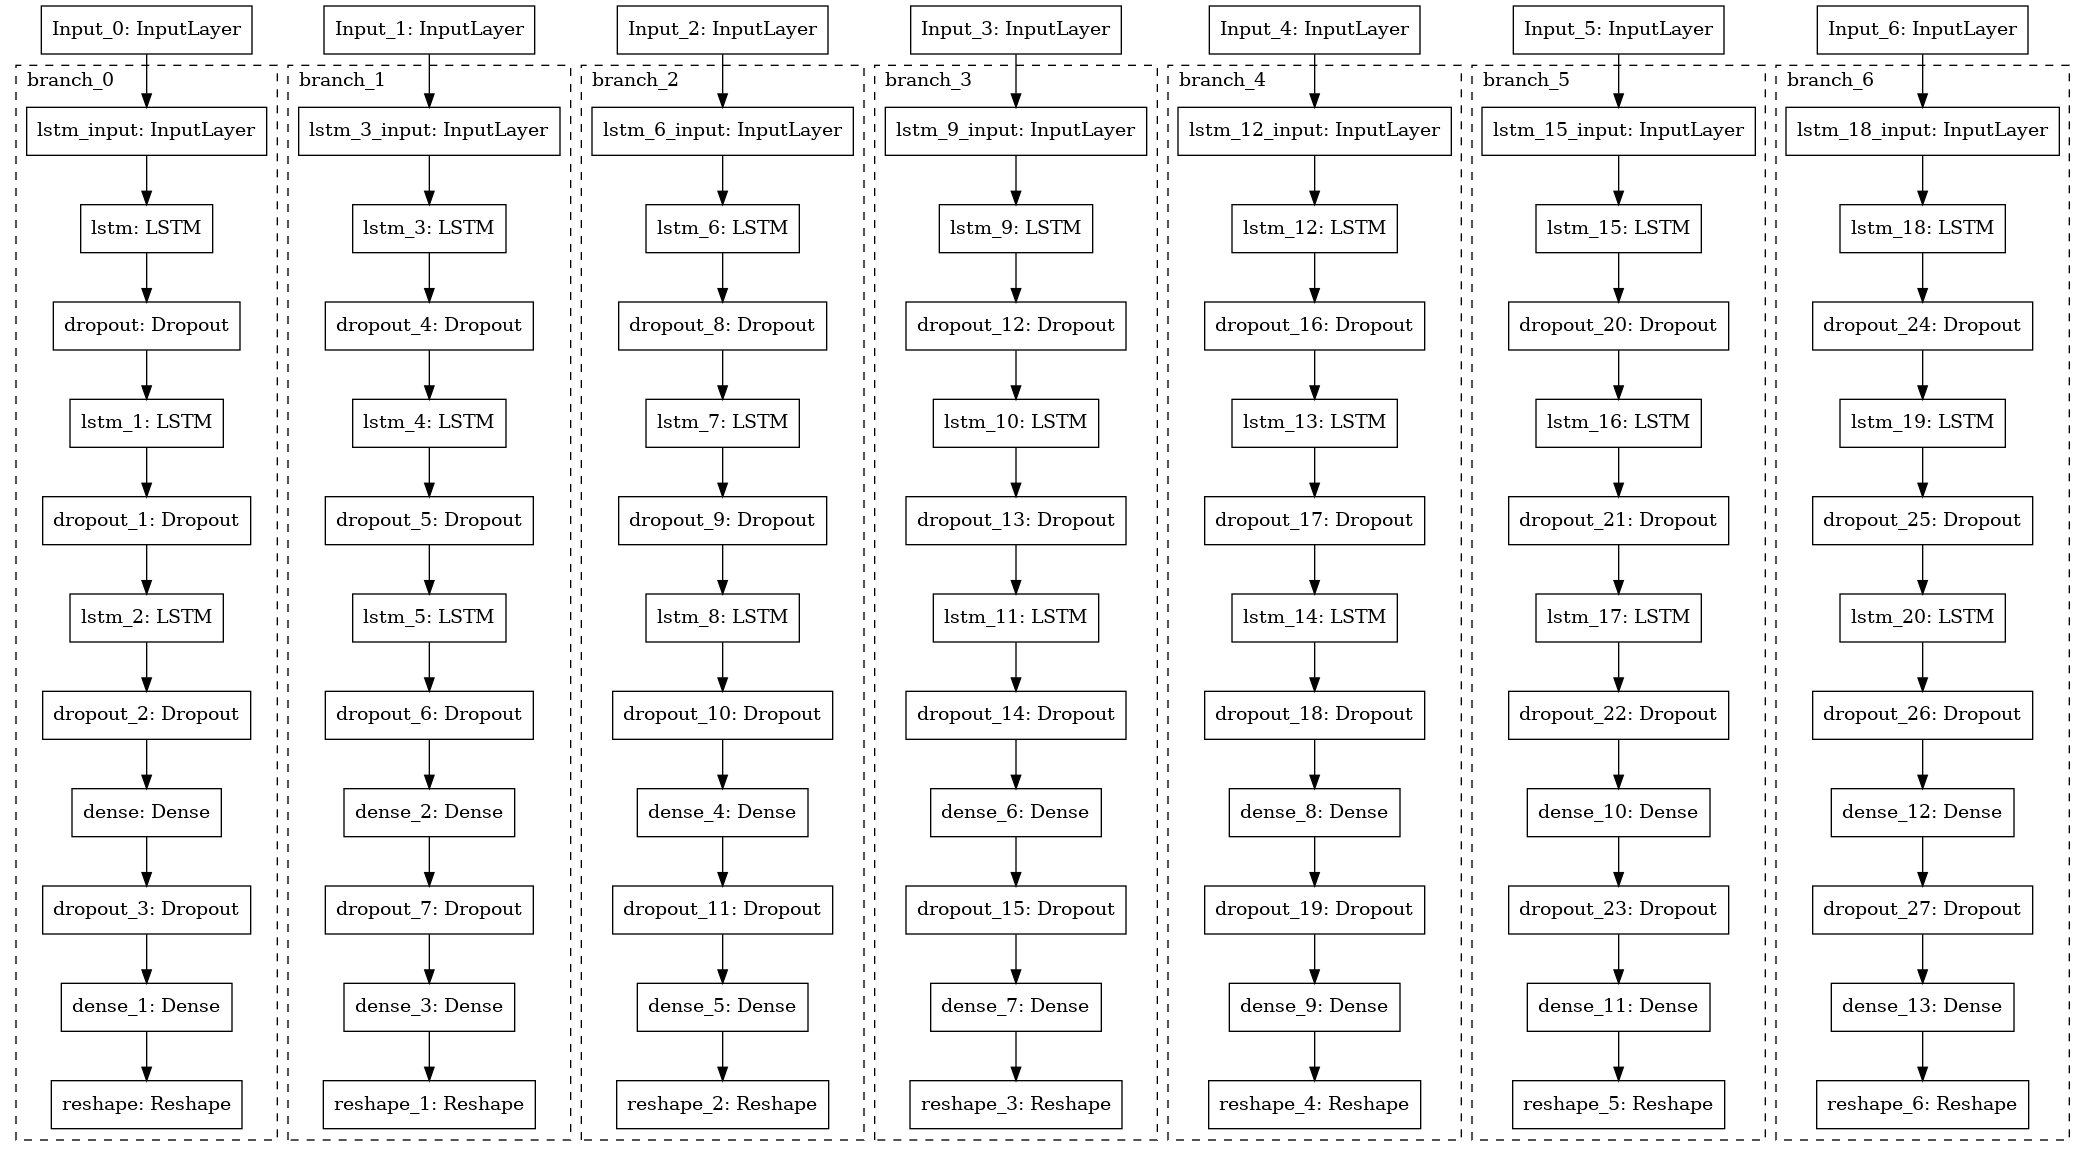

In [15]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

Training the model

In [16]:
patience_ES=100
patience_RLR=50
factor_RLR=0.5
min_LR=1e-5

In [17]:
#training the model
print(X_train.shape)
print(y_train.shape)

x_fit={
    "Input_0":X_train[:,:,0],
    "Input_1":X_train[:,:,1],
    "Input_2":X_train[:,:,2],
    "Input_3":X_train[:,:,3],
    "Input_4":X_train[:,:,4],
    "Input_5":X_train[:,:,5],
    "Input_6":X_train[:,:,6]
}

y_fit={
    "branch_0": y_train[:,:,0],
    "branch_1": y_train[:,:,1],
    "branch_2": y_train[:,:,2],
    "branch_3": y_train[:,:,3],
    "branch_4": y_train[:,:,4],
    "branch_5": y_train[:,:,5],
    "branch_6": y_train[:,:,6]
}

history = model.fit(
    x = x_fit,
    y = y_fit,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,    #use 10% of values as validation set
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience_ES, restore_best_weights=True), #early stopping and restore best weights
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=patience_RLR, factor=factor_RLR, min_lr=min_LR) #decrease learing rate 
    ]
).history

(574, 100, 7)
(574, 864, 7)
Epoch 1/5000


2022-01-12 14:45:35.464230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-12 14:46:00.745595: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 34s 2s/step - loss: 1.9013 - branch_0_loss: 0.1838 - branch_1_loss: 0.2341 - branch_2_loss: 0.3958 - branch_3_loss: 0.2350 - branch_4_loss: 0.2395 - branch_5_loss: 0.1704 - branch_6_loss: 0.4427 - branch_0_mae: 0.4105 - branch_1_mae: 0.4657 - branch_2_mae: 0.6120 - branch_3_mae: 0.4643 - branch_4_mae: 0.4661 - branch_5_mae: 0.3769 - branch_6_mae: 0.6467 - val_loss: 1.0125 - val_branch_0_loss: 0.1278 - val_branch_1_loss: 0.1461 - val_branch_2_loss: 0.2628 - val_branch_3_loss: 0.1167 - val_branch_4_loss: 0.0977 - val_branch_5_loss: 0.0106 - val_branch_6_loss: 0.2508 - val_branch_0_mae: 0.3179 - val_branch_1_mae: 0.3472 - val_branch_2_mae: 0.4662 - val_branch_3_mae: 0.2907 - val_branch_4_mae: 0.2619 - val_branch_5_mae: 0.0851 - val_branch_6_mae: 0.4428
Epoch 2/5000
5/5 [==============================] - 1s 176ms/step - loss: 0.8658 - branch_0_loss: 0.0870 - branch_1_loss: 0.1121 - branch_2_loss: 0.1766 - branch_3_loss: 0.1052 - branch_4_loss: 0.1102 

Plot errors and learning rate

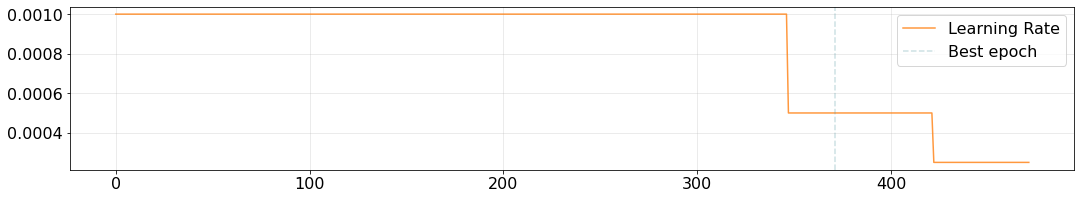

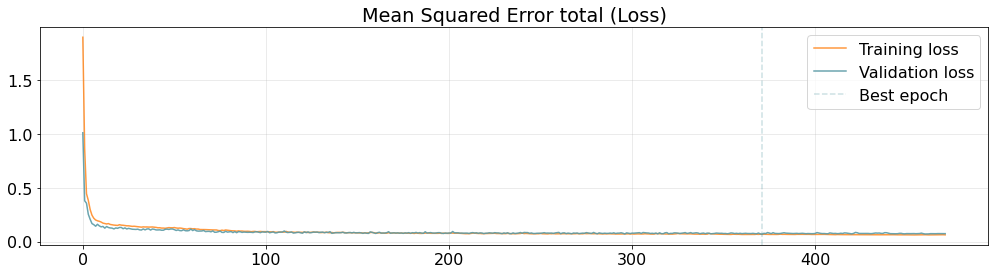

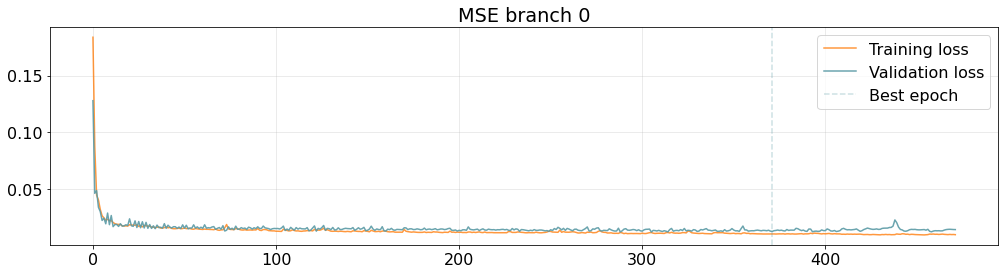

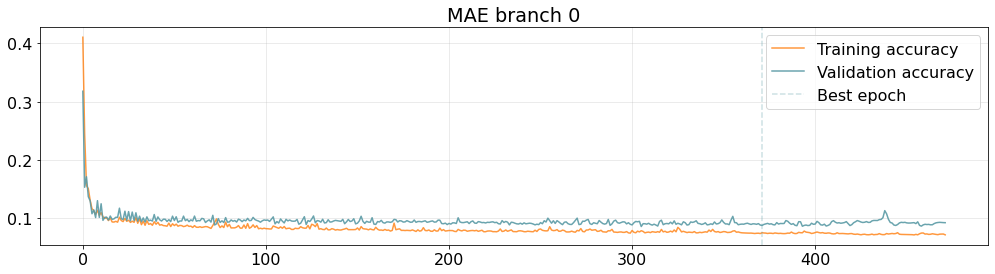

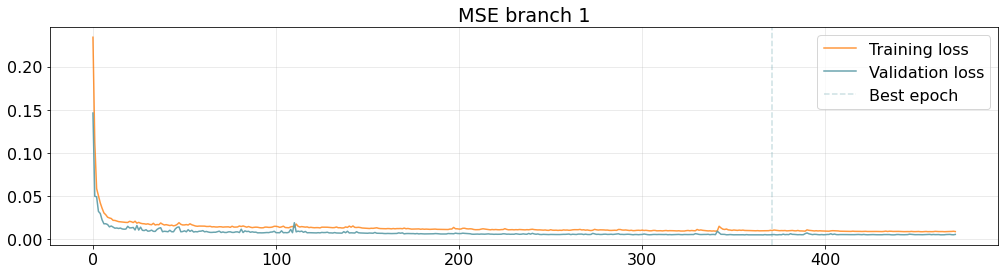

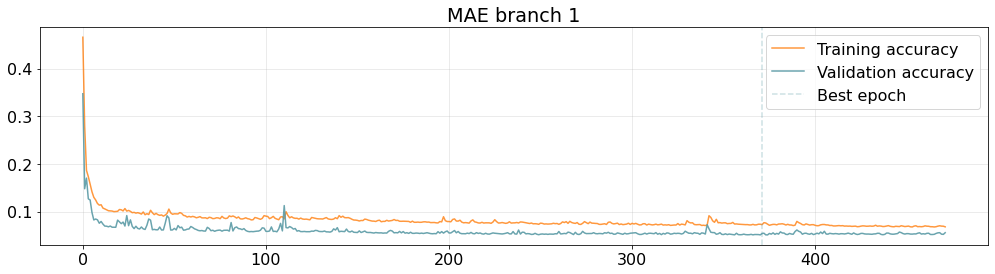

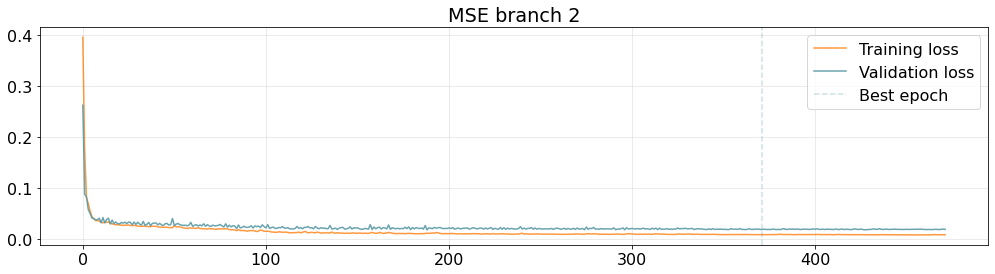

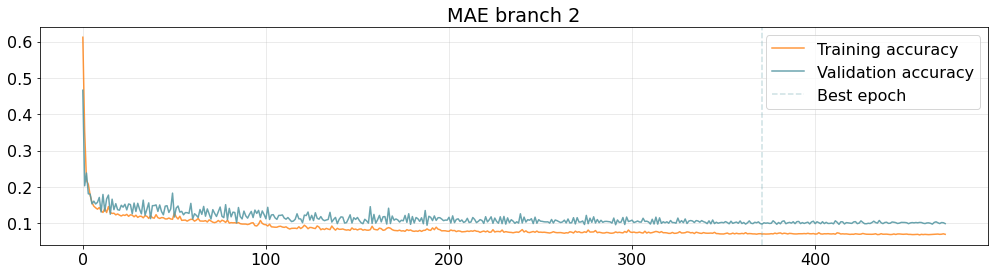

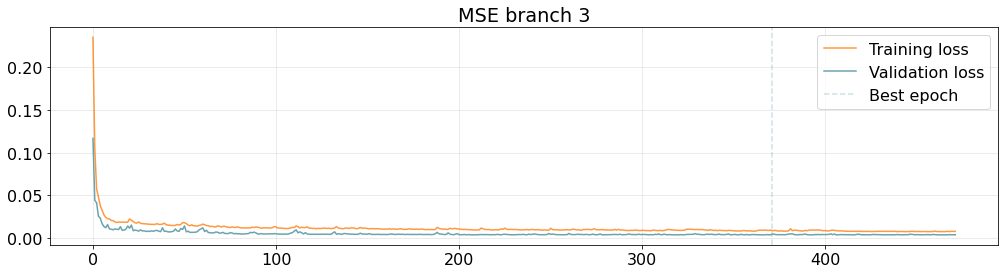

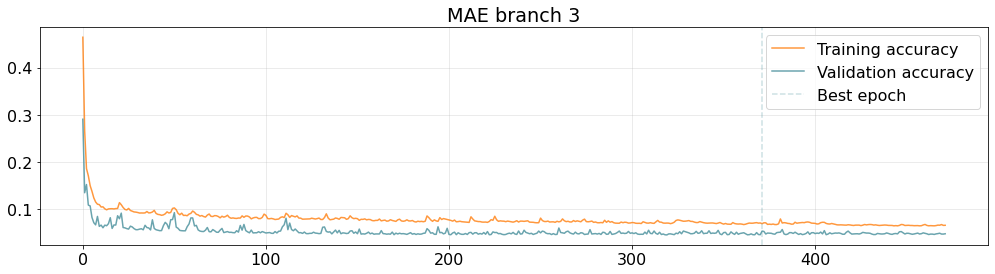

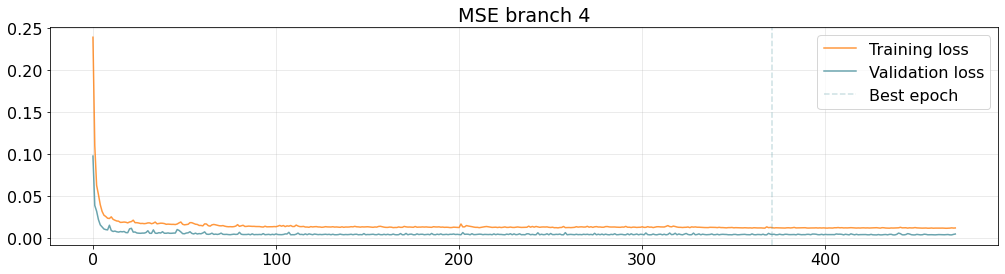

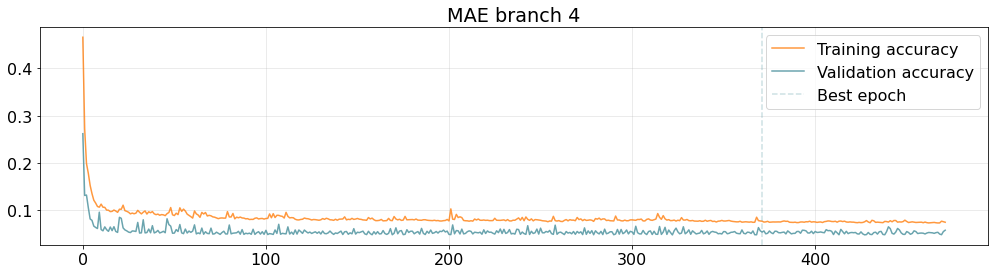

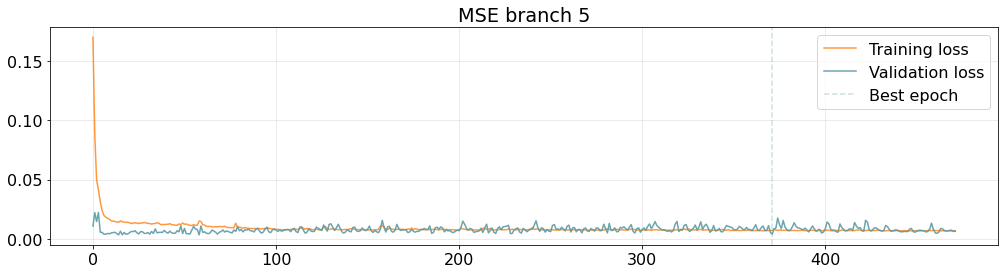

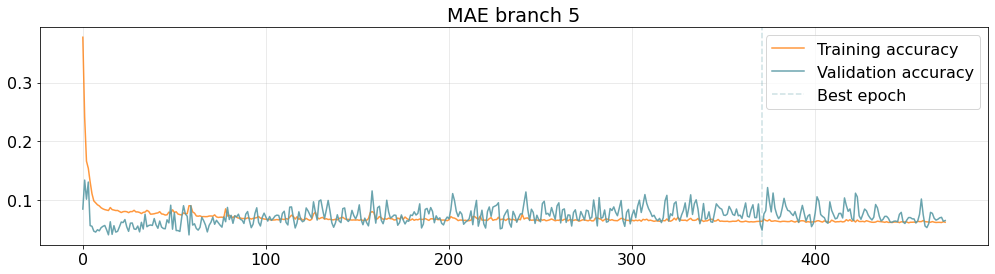

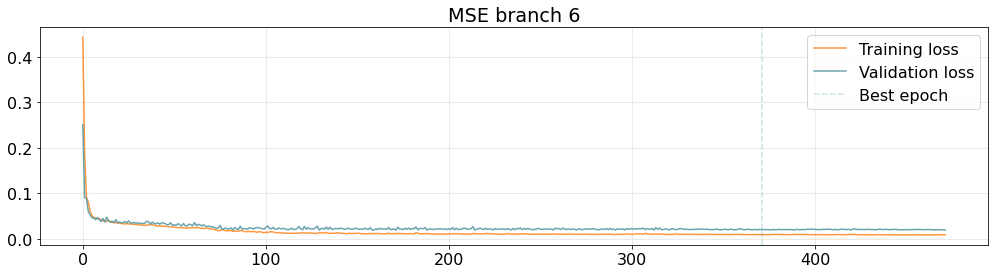

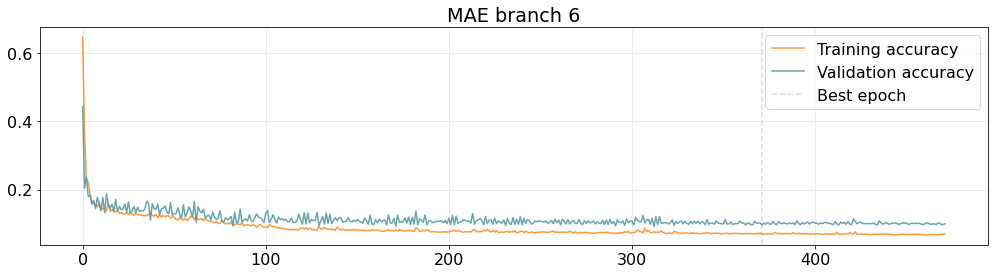

In [18]:
def plot_MSE_MAE_LR(history,shape):

    #define as best epoch the one minimizing validation loss
    best_epoch = np.argmin(history['val_loss'])
    
    #Plot the effect of callback that decreases the learining rate
    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()
    
    #plot MSE of training and validation
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error total (Loss)')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()
    
    #function to print losses for every output branch
    for i in range(shape):
    
        plt.figure(figsize=(17,4))
        plt.plot(history['branch_'+str(i)+'_loss'], label='Training loss', alpha=.8, color='#ff7f0e')
        plt.plot(history['val_'+'branch_'+str(i)+'_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
        plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
        plt.title('MSE branch '+str(i))
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()

        #plot MAE of training and validation
        plt.figure(figsize=(17,4))
        plt.plot(history['branch_'+str(i)+'_mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
        plt.plot(history['val_'+'branch_'+str(i)+'_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
        plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
        plt.title('MAE branch '+str(i))
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()

    

plot_MSE_MAE_LR(history,output_shape[-1])

Save the model

In [19]:
model.save('DirectForecasting')
#model = tfk.models.load_model('DirectForecasting')

2022-01-12 14:54:03.893912: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Predicting Test set

In [20]:
#function to show one example of prediction in a sequence (taken from the test set)
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [21]:
# Predict the test set 
x_predict={
    "Input_0":X_test[:,:,0],
    "Input_1":X_test[:,:,1],
    "Input_2":X_test[:,:,2],
    "Input_3":X_test[:,:,3],
    "Input_4":X_test[:,:,4],
    "Input_5":X_test[:,:,5],
    "Input_6":X_test[:,:,6]
}

predictions = model.predict(x_predict)
print(predictions[0].shape)

#reshape the 7 outputs into 1
predictions=np.array(predictions)
predictions=np.swapaxes(predictions,0,3)[0]
print(predictions.shape)


mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(94, 864, 1)
(94, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.012078191>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.079972886>)

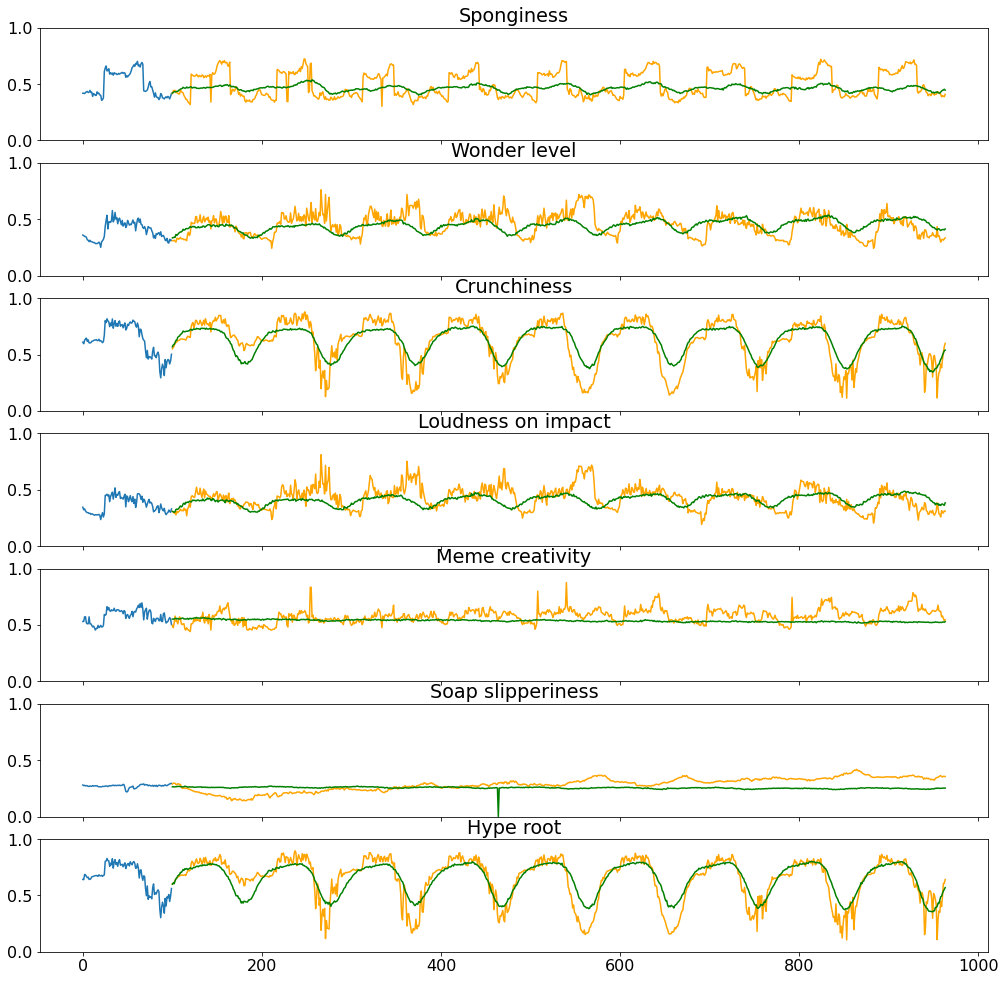

In [22]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

Predict the future of the time series

In [23]:
#future is the very last window that we will use to predict outside the dataset, We won't have target for that prediction
future = dataset[-window:]  #take the last 100 instances of the dataset
future = (future-X_min)/(X_max-X_min) #normalize the values using again the training set
future = np.expand_dims(future, axis=0) #add 1 as first dimension
future.shape #print the shape of future

(1, 100, 7)

In [24]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [25]:
#predict the future
future_fit={
    "Input_0":future[:,:,0],
    "Input_1":future[:,:,1],
    "Input_2":future[:,:,2],
    "Input_3":future[:,:,3],
    "Input_4":future[:,:,4],
    "Input_5":future[:,:,5],
    "Input_6":future[:,:,6]  
}
future_predictions = model.predict(future_fit)
future_predictions=np.array(future_predictions)
future_predictions=np.swapaxes(future_predictions,0,3)[0]

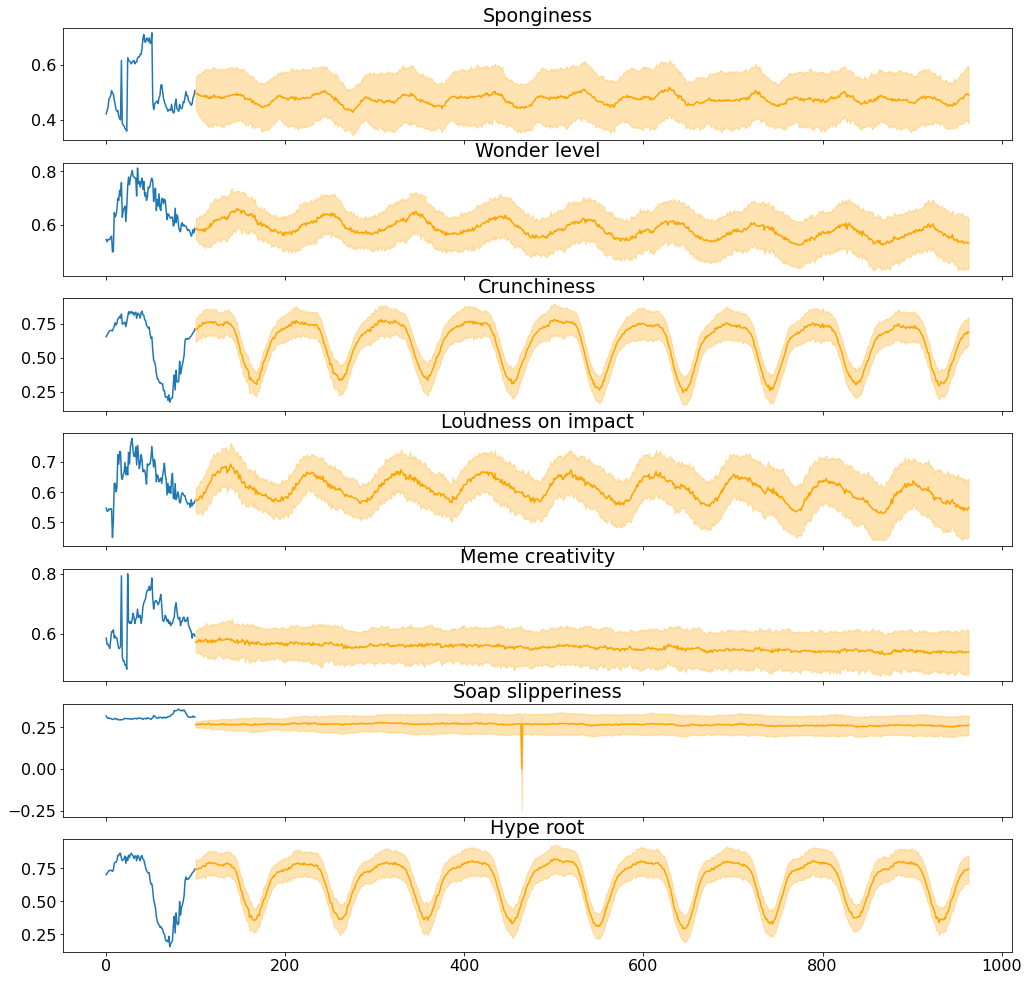

In [26]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()